<a href="https://colab.research.google.com/github/ftaheri/neural_networks/blob/main/emotionsFromAudio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from keras.utils import np_utils

from tqdm import tqdm
import pickle
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd ~
%cd /content/gdrive/My Drive/neuralNetwork/P4_1

Mounted at /content/gdrive
/root
/content/gdrive/.shortcut-targets-by-id/1HbN5FnCSVwNDLF7rT7G5YXvavvGs3DFN/neuralNetwork/P4_1


# Preprocessing

In [ ]:
!ls

dataset			   mfcc_female_voices.pkl
loaded_female_voices2.pkl  mfcc_male_voices2.pkl
loaded_female_voices.pkl   mfcc_male_voices.pkl
loaded_male_voices2.pkl    ser.ipynb
loaded_male_voices.pkl	   sharif-emotional-speech-database
mfcc_female_voices2.pkl


In [ ]:
# nothing important (reports size of the variables on the memory)
import sys
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                        key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                          tqdm:  1.0 KiB
                           _i4:  570.0 B
                          _iii:  343.0 B
                           _i1:  343.0 B
                           _oh:  240.0 B
                           Out:  240.0 B
                           _ii:  184.0 B
                           _i2:  184.0 B
              train_test_split:  136.0 B
                    sizeof_fmt:  136.0 B


In [ ]:
ls dataset/male | head -10

In [ ]:
ls dataset/female | head -10

In [ ]:
male_voice_dir = os.listdir('dataset/male')
female_voice_dir = os.listdir('dataset/female')
female_voice_dir = ['dataset/female/'+i for i in female_voice_dir]
male_voice_dir = ['dataset/male/'+i for i in male_voice_dir]
voice_dir = female_voice_dir+male_voice_dir

In [ ]:
n_mfcc = 60

In [ ]:
# generate mfcc features for male voices
voices      = []
mfccs       = []
for voice in tqdm(male_voice_dir):
    voice_load = librosa.load('dataset/male/'+voice)
    voices.append(voice_load)
    mfccs.append(librosa.feature.mfcc(y=voice_load[0], sr=voice_load[1], n_mfcc=n_mfcc))

100%|██████████| 1737/1737 [16:44<00:00,  1.73it/s]


In [ ]:
# generate mfcc features for female voices
voices_female      = []
mfccs_female      = []
for voice in tqdm(female_voice_dir):
    female_voice_load = librosa.load('dataset/female/'+voice)
    voices_female.append(voice_load)
    mfccs_female.append(librosa.feature.mfcc(y=female_voice_load[0], sr=female_voice_load[1], n_mfcc=n_mfcc))

100%|██████████| 1263/1263 [13:20<00:00,  1.58it/s]


In [ ]:
import pickle
pickle.dump(voices, open('loaded_male_voices2.pkl', 'wb'))
pickle.dump(mfccs, open('mfcc_male_voices2.pkl', 'wb'))

In [ ]:
pickle.dump(voices_female, open('loaded_female_voices2.pkl', 'wb'))
pickle.dump(mfccs_female, open('mfcc_female_voices2.pkl', 'wb'))

In [ ]:
# generate label list
male_voice_label = []
for i in male_voice_dir:
    if 'A' in i:
        male_voice_label.append(0)
    elif 'H' in i:
        male_voice_label.append(1)
    elif 'S' in i:
        male_voice_label.append(2)
    elif 'W' in i:
        male_voice_label.append(3)
    elif 'N' in i:
        male_voice_label.append(4)
    elif 'F' in i:
        male_voice_label.append(5)
    else:
        print(i)

In [ ]:
# generate label list
female_voice_label = []
for i in female_voice_dir:
    if 'A' in i:
        female_voice_label.append(0)
    elif 'H' in i:
        female_voice_label.append(1)
    elif 'S' in i:
        female_voice_label.append(2)
    elif 'W' in i:
        female_voice_label.append(3)
    elif 'N' in i:
        female_voice_label.append(4)
    elif 'F' in i:
        female_voice_label.append(5)
    else:
        print(i)

In [ ]:
emotion_classes = [0,1,2,3,4,5]

In [ ]:
assert len(set(male_voice_label)) == len(emotion_classes)
assert len(set(female_voice_label)) == len(emotion_classes)

In [ ]:
male_mfccs = pickle.load(open('mfcc_male_voices2.pkl', 'rb'))
female_mfccs = pickle.load(open('mfcc_female_voices2.pkl', 'rb'))

In [ ]:
mfccs = female_mfccs+male_mfccs
voice_label = female_voice_label+male_voice_label
print(len(mfccs), len(voice_label))

In [ ]:
voice_label = female_voice_label+male_voice_label

mean 178.2959124928037
mode ModeResult(mode=array([110]), count=array([15]))
median 138.0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


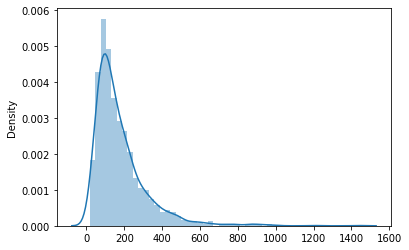

In [ ]:
male_mfcc_length = [i.shape[1] for i in male_mfccs]
assert [i.shape[0] for i in male_mfccs] == [n_mfcc for i in male_mfccs]

# stats about length
male_mean = np.mean(male_mfcc_length)
male_mode = stats.mode(male_mfcc_length)
male_median = np.median(male_mfcc_length)
print('mean', np.mean(male_mfcc_length))
print('mode', stats.mode(male_mfcc_length))
print('median', np.median(male_mfcc_length))

# distribution of mfcc length
sns.distplot(male_mfcc_length)

mean 176.6294536817102
mode ModeResult(mode=array([60]), count=array([12]))
median 128.0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


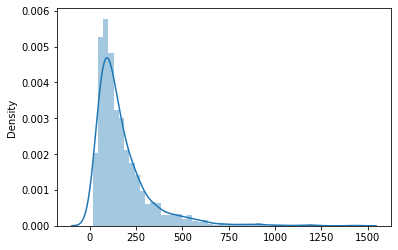

In [ ]:
female_mfcc_length = [i.shape[1] for i in female_mfccs]
assert [i.shape[0] for i in female_mfccs] == [n_mfcc for i in female_mfccs]

# stats about length
female_mean = np.mean(female_mfcc_length)
female_mode = stats.mode(female_mfcc_length)
female_median = np.median(female_mfcc_length)
print('mean', np.mean(female_mfcc_length))
print('mode', stats.mode(female_mfcc_length))
print('median', np.median(female_mfcc_length))

# distribution of mfcc length
sns.distplot(female_mfcc_length)

mean 177.59433333333334
mode ModeResult(mode=array([79]), count=array([24]))
median 133.0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


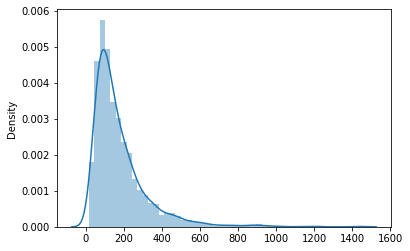

In [ ]:
mfcc_length = [i.shape[1] for i in mfccs]
assert [i.shape[0] for i in mfccs] == [n_mfcc for i in mfccs]

# stats about length
mean = np.mean(mfcc_length)
mode = stats.mode(mfcc_length)
median = np.median(mfcc_length)
print('mean', np.mean(mfcc_length))
print('mode', stats.mode(mfcc_length))
print('median', np.median(mfcc_length))

# distribution of mfcc length
sns.distplot(mfcc_length)

In [ ]:
len(mfccs)

3000

## Sample Output

In [ ]:
print(male_voice_label[877], male_voice_label[15])

4 0


In [ ]:
import IPython
IPython.display.Audio(f"dataset/male/{male_voice_dir[877]}")
# IPython.display.Audio(f"dataset/male/M03F01.wav")

## Padding

In [ ]:
# size of the flattened mfcc features
male_mean_mfcc_size = int(n_mfcc * male_median)
female_mean_mfcc_size = int(n_mfcc * female_median)
mean_mfcc_size = int(n_mfcc * median)
print(mean_mfcc_size, female_mean_mfcc_size, male_mean_mfcc_size)

7980 7680 8280


mixture

In [ ]:
minn=mfccs[0][0][0]
for i in mfccs:
  for j in i:
    for k in j:
      if (k<minn):
        minn=k

In [ ]:
minn

-696.2844982228476

In [ ]:
# padding and masking for mfcc features
mfccs_flatten = [mfcc.flatten()+700 for mfcc in mfccs] # make every 2D feature flatten and greater than zero
for i in range(len(mfccs_flatten)):
    # truncate longer sequences to the median length for sequences
    # so it wouldn't be the case that smaller seqs. get ignored.
    if len(mfccs_flatten[i]) > mean_mfcc_size:
        mfccs_flatten[i] = mfccs_flatten[i][:mean_mfcc_size]
padded_mfcc = tf.keras.preprocessing.sequence.pad_sequences(
    mfccs_flatten, padding='post'
)
# print(padded_mfcc[:10])

# output dimension assertion
assert [len(i) for i in padded_mfcc] == [len(padded_mfcc[0]) for i in padded_mfcc]
print(len(padded_mfcc[0]))

# masking layer (test)
# embedding = tf.keras.layers.Embedding(input_dim=1000, output_dim=16, mask_zero=True)
# masked_output = embedding(padded_mfcc)
# print(masked_output._keras_mask)

7980


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


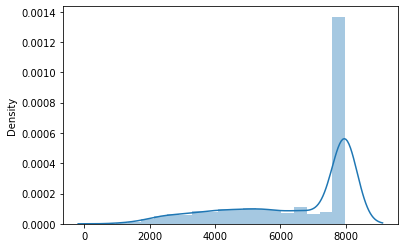

In [ ]:
sns.distplot([len(i) for i in mfccs_flatten])

female

In [ ]:
minn_female=female_mfccs[0][0][0]
for i in female_mfccs:
  for j in i:
    for k in j:
      if (k<minn_female):
        minn_female=k

In [ ]:
minn_female

-665.4552153056302

In [ ]:
# padding and masking for mfcc features
female_mfccs_flatten = [female_mfcc.flatten()+700 for female_mfcc in female_mfccs] # make every 2D feature flatten and greater than zero
for i in range(len(female_mfccs_flatten)):
    # truncate longer sequences to the median length for sequences
    # so it wouldn't be the case that smaller seqs. get ignored.
    if len(female_mfccs_flatten[i]) > mean_mfcc_size:
        female_mfccs_flatten[i] = female_mfccs_flatten[i][:mean_mfcc_size]
female_padded_mfcc = tf.keras.preprocessing.sequence.pad_sequences(
    female_mfccs_flatten, padding='post'
)
# print(padded_mfcc[:10])

# output dimension assertion
assert [len(i) for i in female_padded_mfcc] == [len(female_padded_mfcc[0]) for i in female_padded_mfcc]
print(len(female_padded_mfcc[0]))

# masking layer (test)
# embedding = tf.keras.layers.Embedding(input_dim=1000, output_dim=16, mask_zero=True)
# masked_output = embedding(padded_mfcc)
# print(masked_output._keras_mask)

7980


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


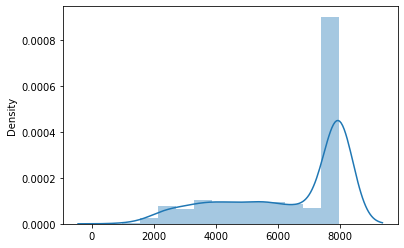

In [ ]:
sns.distplot([len(i) for i in female_mfccs_flatten])

male

In [ ]:
# padding and masking for mfcc features
male_mfccs_flatten = [male_mfcc.flatten()+700 for male_mfcc in male_mfccs] # make every 2D feature flatten and greater than zero
for i in range(len(male_mfccs_flatten)):
    # truncate longer sequences to the median length for sequences
    # so it wouldn't be the case that smaller seqs. get ignored.
    if len(male_mfccs_flatten[i]) > male_mean_mfcc_size:
        male_mfccs_flatten[i] = male_mfccs_flatten[i][:mean_mfcc_size]
male_padded_mfcc = tf.keras.preprocessing.sequence.pad_sequences(
    male_mfccs_flatten, padding='post'
)
# print(padded_mfcc[:10])

# output dimension assertion
assert [len(i) for i in male_padded_mfcc] == [len(male_padded_mfcc[0]) for i in male_padded_mfcc]
print(len(male_padded_mfcc[0]))

# masking layer (test)
# embedding = tf.keras.layers.Embedding(input_dim=1000, output_dim=16, mask_zero=True)
# masked_output = embedding(padded_mfcc)
# print(masked_output._keras_mask)

8280


In [ ]:
print(len(female_voice_label), len(female_padded_mfcc), len(female_mfccs_flatten))

1263 1263 1263




# Some plotting

In [ ]:
import numpy as np
y1, sr1 = librosa.load('dataset/male/M01H01.wav')
y2, sr2 = librosa.load('dataset/male/M01N01.wav')
time1 = np.arange(0, len(y1))/sr1
time2 = np.arange(0, len(y2))/sr2

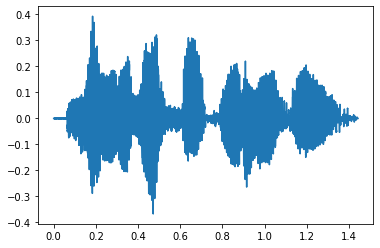

In [ ]:
fig, ax = plt.subplots()
ax.plot(time2, y2)

In [ ]:
np.mean(librosa.feature.mfcc(y=y1, sr=sr1, n_mfcc=13).T, axis=0)

array([-290.60158637,  108.6126721 ,    6.02507346,    8.21542886,
        -14.83711535,    9.18470279,  -10.47517531,   17.4834219 ,
        -31.56983377,   20.74570815,  -22.57777501,   -1.67516849,
         -3.26567531])

In [ ]:
librosa.feature.mfcc(y=y1, sr=sr1, n_mfcc=13).T.shape

(90, 13)

/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:888: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  warnings.warn('power_to_db was called on complex input so phase '


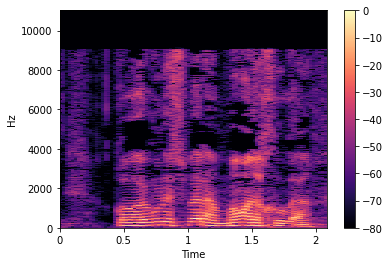

In [ ]:

D1 = librosa.stft(y1)
D2 = librosa.stft(y2)
log_power = librosa.power_to_db(D1**2, ref=np.max)
librosa.display.specshow(log_power, x_axis='time', y_axis='linear')
plt.colorbar()

In [ ]:
for i in range(5):
    y, sr = librosa.load(voice_dir[i])
    D = np.mean(librosa.feature.melspectrogram(y, sr=sr, fmax=8000).T, axis=0)
    print(D.shape)

(128,)
(128,)
(128,)
(128,)
(128,)


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

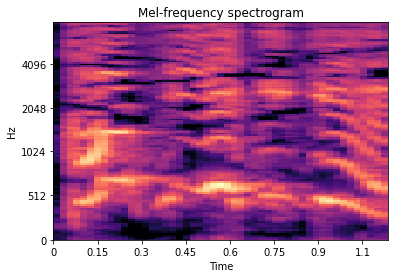

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(D, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
# fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

[Text(0.5, 1.0, 'MFCC')]

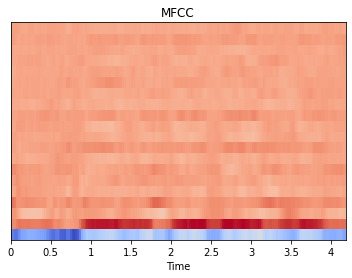

In [ ]:
mfc1 = librosa.feature.mfcc(y=y1, sr=sr1)
# mfc2 = librosa.feature.mfcc(y=y2, sr=sr2)
fig, ax = plt.subplots()
img = librosa.display.specshow(mfc1, x_axis='time', ax=ax)
# fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

# Training

## training female and male data seperately

In [ ]:
x_train_m, x_test_m, y_train_m, y_test_m = train_test_split(male_padded_mfcc, male_voice_label, test_size=0.4)
y_train_m = np_utils.to_categorical(y_train_m, num_classes=len(emotion_classes))
y_test_m  = np_utils.to_categorical(y_test_m, num_classes=len(emotion_classes))
x_test_m, x_val_m, y_test_m, y_val_m = train_test_split(x_test_m, y_test_m, test_size=0.5)

In [ ]:
print(len(x_train_m), len(x_val_m), len(x_test_m))

1042 348 347


In [ ]:
y_train.shape

(1042, 6)

In [ ]:
from tensorflow.keras.layers import Bidirectional, LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=1000, output_dim=40, mask_zero=True),
    Bidirectional(LSTM(32, return_sequences=True)),
    LSTM(32),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(len(emotion_classes), activation='softmax')
])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

In [ ]:
BATCH_SIZE = 64
EPOCHS = 5

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train_m, y_train_m,
                    validation_data=(x_val_m, y_val_m),
                    callbacks=[early_stopping],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS)

Epoch 1/5
17/17 [==============================] - 344s 20s/step - loss: 1.7423 - accuracy: 0.4404 - val_loss: 1.4837 - val_accuracy: 0.4224
Epoch 2/5
17/17 [==============================] - 332s 20s/step - loss: 1.4177 - accuracy: 0.4378 - val_loss: 1.4153 - val_accuracy: 0.4224
Epoch 3/5
17/17 [==============================] - 337s 20s/step - loss: 1.3116 - accuracy: 0.4395 - val_loss: 1.3497 - val_accuracy: 0.4224
Epoch 4/5
 1/17 [>.............................] - ETA: 5:16 - loss: 1.3462 - accuracy: 0.4375

## training mixed data

normalizing

In [ ]:
# padded_mfcc = (padded_mfcc-padded_mfcc.min(axis=0))/(padded_mfcc.max(axis=0)-padded_mfcc.min(axis=0))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(padded_mfcc, voice_label, test_size=0.4 ,shuffle=True)
y_train = np_utils.to_categorical(y_train, num_classes=len(emotion_classes))
y_test  = np_utils.to_categorical(y_test, num_classes=len(emotion_classes))
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

In [ ]:
print(len(x_train), len(x_val), len(x_test))

1800 600 600


In [ ]:
y_train.shape

(1800, 6)

In [ ]:
from tensorflow.keras.layers import Bidirectional, LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=7980, output_dim=n_mfcc, mask_zero=True),
    Bidirectional(LSTM(60, return_sequences=True)),
    LSTM(60),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(len(emotion_classes), activation='softmax')
])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)

In [ ]:
from tensorflow import keras
BATCH_SIZE = 64
EPOCHS = 10
opt=keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS)

Epoch 1/10
29/29 [==============================] - 39s 1s/step - loss: 1.7511 - accuracy: 0.3175 - val_loss: 1.6818 - val_accuracy: 0.3867
Epoch 2/10
29/29 [==============================] - 28s 980ms/step - loss: 1.5505 - accuracy: 0.4048 - val_loss: 1.5730 - val_accuracy: 0.3883
Epoch 3/10
29/29 [==============================] - 28s 975ms/step - loss: 1.4942 - accuracy: 0.4129 - val_loss: 1.5055 - val_accuracy: 0.3783
Epoch 4/10
29/29 [==============================] - 28s 978ms/step - loss: 1.4210 - accuracy: 0.4363 - val_loss: 1.4969 - val_accuracy: 0.3917
Epoch 5/10
29/29 [==============================] - 28s 980ms/step - loss: 1.4351 - accuracy: 0.4337 - val_loss: 1.4654 - val_accuracy: 0.3583
Epoch 6/10
29/29 [==============================] - 28s 978ms/step - loss: 1.3886 - accuracy: 0.4506 - val_loss: 1.6778 - val_accuracy: 0.3467


## training a network for each class of feelings (Unsuccessful)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(padded_mfcc, voice_label, test_size=0.2 ,shuffle=True)

In [ ]:
voice_label0=[]
voice_label1=[]
voice_label2=[]
voice_label3=[]
voice_label4=[]
voice_label5=[]
x_train0=[]
x_train1=[]
x_train2=[]
x_train3=[]
x_train4=[]
x_train5=[]
for i in range(len(y_train)):
  label = y_train[i]
  if label==0:
    voice_label0.append(1)
    x_train0.append(x_train[i])
  elif label==1:
    voice_label1.append(1)
    x_train1.append(x_train[i])
  elif label==2:
    voice_label2.append(1)
    x_train2.append(x_train[i])
  elif label==3:
    voice_label3.append(1)
    x_train3.append(x_train[i])
  elif label==4:
    voice_label4.append(1)
    x_train4.append(x_train[i])
  elif label==5:
    voice_label5.append(1)
    x_train5.append(x_train[i])

voice_label0=np.asarray(voice_label0)
voice_label1=np.asarray(voice_label1)
voice_label2=np.asarray(voice_label2)
voice_label3=np.asarray(voice_label3)
voice_label4=np.asarray(voice_label4)
voice_label5=np.asarray(voice_label5)
x_train5=np.asarray(x_train5)
x_train4=np.asarray(x_train4)
x_train3=np.asarray(x_train3)
x_train2=np.asarray(x_train2)
x_train1=np.asarray(x_train1)
x_train0=np.asarray(x_train0)

emotion 0 network (Anger)

In [ ]:
x_train0, x_val0, y_train0, y_val0 = train_test_split(x_train0, voice_label0, test_size=0.3 ,shuffle=True)
y_train0 = np_utils.to_categorical(y_train0,num_classes=2)
y_val0  = np_utils.to_categorical(y_val0,num_classes=2)

In [ ]:
from tensorflow.keras.layers import Bidirectional, LSTM
model0 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=7980, output_dim=n_mfcc, mask_zero=True),
    Bidirectional(LSTM(32, return_sequences=True)),
    LSTM(1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

In [ ]:
BATCH_SIZE = 64
EPOCHS = 10

model0.compile(loss='mae', optimizer='adam')
history = model0.fit(x_train0, y_train0,
                    validation_data=(x_val0, y_val0),
                    callbacks=[early_stopping],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS)

Epoch 1/10
10/10 [==============================] - 22s 1s/step - loss: 0.4841 - val_loss: 0.4121
Epoch 2/10
10/10 [==============================] - 9s 880ms/step - loss: 0.3676 - val_loss: 0.2067
Epoch 3/10
10/10 [==============================] - 9s 888ms/step - loss: 0.1673 - val_loss: 0.0740
Epoch 4/10
10/10 [==============================] - 9s 884ms/step - loss: 0.0608 - val_loss: 0.0327
Epoch 5/10
10/10 [==============================] - 9s 878ms/step - loss: 0.0285 - val_loss: 0.0188
Epoch 6/10
10/10 [==============================] - 9s 877ms/step - loss: 0.0171 - val_loss: 0.0128
Epoch 7/10
10/10 [==============================] - 9s 898ms/step - loss: 0.0119 - val_loss: 0.0096
Epoch 8/10
10/10 [==============================] - 9s 883ms/step - loss: 0.0091 - val_loss: 0.0077
Epoch 9/10
10/10 [==============================] - 9s 891ms/step - loss: 0.0073 - val_loss: 0.0063
Epoch 10/10
10/10 [==============================] - 9s 889ms/step - loss: 0.0060 - val_loss: 0.0053


emotion 1 network (Happiness)

In [ ]:
x_train1, x_val1, y_train1, y_val1 = train_test_split(x_train1, voice_label1, test_size=0.3 ,shuffle=True)
y_train1 = np_utils.to_categorical(y_train1)
y_val1  = np_utils.to_categorical(y_val1)

In [ ]:
from tensorflow.keras.layers import Bidirectional, LSTM
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=7980, output_dim=n_mfcc, mask_zero=True),
    Bidirectional(LSTM(32, return_sequences=True)),
    LSTM(32),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
BATCH_SIZE = 64
EPOCHS = 20

model1.compile(loss='binary_crossentropy', optimizer='adam')
history = model1.fit(x_train1, y_train1,
                    validation_data=(x_val1, y_val1),
                    callbacks=[early_stopping],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS)

Epoch 1/20
2/2 [==============================] - 15s 6s/step - loss: 0.6926 - val_loss: 0.6838
Epoch 2/20
2/2 [==============================] - 2s 1s/step - loss: 0.6821 - val_loss: 0.6701
Epoch 3/20
2/2 [==============================] - 2s 1s/step - loss: 0.6677 - val_loss: 0.6517
Epoch 4/20
2/2 [==============================] - 2s 1s/step - loss: 0.6484 - val_loss: 0.6260
Epoch 5/20
2/2 [==============================] - 2s 1s/step - loss: 0.6212 - val_loss: 0.5886
Epoch 6/20
2/2 [==============================] - 2s 1s/step - loss: 0.5813 - val_loss: 0.5338
Epoch 7/20
2/2 [==============================] - 2s 1s/step - loss: 0.5228 - val_loss: 0.4553
Epoch 8/20
2/2 [==============================] - 2s 1s/step - loss: 0.4405 - val_loss: 0.3588
Epoch 9/20
2/2 [==============================] - 2s 1s/step - loss: 0.3441 - val_loss: 0.2682
Epoch 10/20
2/2 [==============================] - 2s 1s/step - loss: 0.2575 - val_loss: 0.2041
Epoch 11/20
2/2 [==============================]

emotion 2 network (Sadness)

In [ ]:
x_train2, x_val2, y_train2, y_val2 = train_test_split(x_train2, voice_label2, test_size=0.4 ,shuffle=True)
y_train2 = np_utils.to_categorical(y_train2)
y_val2  = np_utils.to_categorical(y_val2)

In [ ]:
from tensorflow.keras.layers import Bidirectional, LSTM
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=7980, output_dim=n_mfcc, mask_zero=True),
    Bidirectional(LSTM(32, return_sequences=True)),
    LSTM(32),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
BATCH_SIZE = 64
EPOCHS = 20

model2.compile(loss='binary_crossentropy', optimizer='adam')
history = model2.fit(x_train2, y_train2,
                    validation_data=(x_val2, y_val2),
                    callbacks=[early_stopping],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS)

Epoch 1/20
4/4 [==============================] - 15s 2s/step - loss: 0.6801 - val_loss: 0.6249
Epoch 2/20
4/4 [==============================] - 4s 1s/step - loss: 0.6035 - val_loss: 0.4851
Epoch 3/20
4/4 [==============================] - 4s 1s/step - loss: 0.4452 - val_loss: 0.2751
Epoch 4/20
4/4 [==============================] - 4s 1s/step - loss: 0.2457 - val_loss: 0.1526
Epoch 5/20
4/4 [==============================] - 4s 1s/step - loss: 0.1394 - val_loss: 0.0954
Epoch 6/20
4/4 [==============================] - 4s 1s/step - loss: 0.0883 - val_loss: 0.0647
Epoch 7/20
4/4 [==============================] - 4s 1s/step - loss: 0.0611 - val_loss: 0.0491
Epoch 8/20
4/4 [==============================] - 4s 1s/step - loss: 0.0472 - val_loss: 0.0407
Epoch 9/20
4/4 [==============================] - 4s 1s/step - loss: 0.0396 - val_loss: 0.0360
Epoch 10/20
4/4 [==============================] - 4s 1s/step - loss: 0.0354 - val_loss: 0.0330
Epoch 11/20
4/4 [==============================]

emotion 3 network (Surprise)

In [ ]:
x_train3, x_val3, y_train3, y_val3 = train_test_split(x_train3, voice_label3, test_size=0.4 ,shuffle=True)
y_train3 = np_utils.to_categorical(y_train3)
y_val3  = np_utils.to_categorical(y_val3)

In [ ]:
from tensorflow.keras.layers import Bidirectional, LSTM
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=7980, output_dim=n_mfcc, mask_zero=True),
    Bidirectional(LSTM(32, return_sequences=True)),
    LSTM(32),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
BATCH_SIZE = 64
EPOCHS = 20

model3.compile(loss='binary_crossentropy', optimizer='adam')
history = model3.fit(x_train3, y_train3,
                    validation_data=(x_val3, y_val3),
                    callbacks=[early_stopping],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS)

Epoch 1/20
2/2 [==============================] - 13s 4s/step - loss: 0.6906 - val_loss: 0.6760
Epoch 2/20
2/2 [==============================] - 2s 1s/step - loss: 0.6736 - val_loss: 0.6542
Epoch 3/20
2/2 [==============================] - 2s 1s/step - loss: 0.6506 - val_loss: 0.6226
Epoch 4/20
2/2 [==============================] - 2s 1s/step - loss: 0.6174 - val_loss: 0.5775
Epoch 5/20
2/2 [==============================] - 2s 1s/step - loss: 0.5701 - val_loss: 0.5156
Epoch 6/20
2/2 [==============================] - 2s 1s/step - loss: 0.5062 - val_loss: 0.4384
Epoch 7/20
2/2 [==============================] - 2s 1s/step - loss: 0.4279 - val_loss: 0.3572
Epoch 8/20
2/2 [==============================] - 2s 1s/step - loss: 0.3471 - val_loss: 0.2852
Epoch 9/20
2/2 [==============================] - 2s 1s/step - loss: 0.2769 - val_loss: 0.2267
Epoch 10/20
2/2 [==============================] - 2s 1s/step - loss: 0.2199 - val_loss: 0.1801
Epoch 11/20
2/2 [==============================]

emotion 4 network (Neutral)

In [ ]:
x_train4, x_val4, y_train4, y_val4 = train_test_split(x_train4, voice_label4, test_size=0.3 ,shuffle=True)
y_train4 = np_utils.to_categorical(y_train4)
y_val4  = np_utils.to_categorical(y_val4)

In [ ]:
from tensorflow.keras.layers import Bidirectional, LSTM
model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=7980, output_dim=n_mfcc, mask_zero=True),
    Bidirectional(LSTM(32, return_sequences=True)),
    LSTM(32),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
BATCH_SIZE = 64
EPOCHS = 20

model4.compile(loss='binary_crossentropy', optimizer='adam')
history = model4.fit(x_train4, y_train4,
                    validation_data=(x_val4, y_val4),
                    callbacks=[early_stopping],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS)

Epoch 1/20
9/9 [==============================] - 22s 1s/step - loss: 0.6693 - val_loss: 0.5458
Epoch 2/20
9/9 [==============================] - 8s 935ms/step - loss: 0.4581 - val_loss: 0.1771
Epoch 3/20
9/9 [==============================] - 8s 941ms/step - loss: 0.1399 - val_loss: 0.0636
Epoch 4/20
9/9 [==============================] - 8s 940ms/step - loss: 0.0543 - val_loss: 0.0363
Epoch 5/20
9/9 [==============================] - 8s 939ms/step - loss: 0.0337 - val_loss: 0.0279
Epoch 6/20
9/9 [==============================] - 8s 950ms/step - loss: 0.0268 - val_loss: 0.0239
Epoch 7/20
9/9 [==============================] - 8s 956ms/step - loss: 0.0232 - val_loss: 0.0213
Epoch 8/20
9/9 [==============================] - 8s 943ms/step - loss: 0.0208 - val_loss: 0.0194
Epoch 9/20
9/9 [==============================] - 8s 933ms/step - loss: 0.0189 - val_loss: 0.0177
Epoch 10/20
9/9 [==============================] - 8s 938ms/step - loss: 0.0174 - val_loss: 0.0163
Epoch 11/20
9/9 [====

emotion 5 network (Fear)

In [ ]:
x_train5, x_val5, y_train5, y_val5 = train_test_split(x_train5, voice_label5, test_size=0.3 ,shuffle=True)
y_train5 = np_utils.to_categorical(y_train5)
y_val5  = np_utils.to_categorical(y_val5)

In [ ]:
from tensorflow.keras.layers import Bidirectional, LSTM
model5 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=7980, output_dim=n_mfcc, mask_zero=True),
    Bidirectional(LSTM(32, return_sequences=True)),
    LSTM(32),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
BATCH_SIZE = 64
EPOCHS = 20

model5.compile(loss='mse', optimizer='adam')
history = model5.fit(x_train5, y_train5,
                    validation_data=(x_val5, y_val5),
                    callbacks=[early_stopping],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS)

Epoch 1/20
1/1 [==============================] - 13s 13s/step - loss: 0.2488 - val_loss: 0.2386
Epoch 2/20
1/1 [==============================] - 1s 927ms/step - loss: 0.2380 - val_loss: 0.2270
Epoch 3/20
1/1 [==============================] - 1s 956ms/step - loss: 0.2260 - val_loss: 0.2137
Epoch 4/20
1/1 [==============================] - 1s 999ms/step - loss: 0.2123 - val_loss: 0.1989
Epoch 5/20
1/1 [==============================] - 1s 954ms/step - loss: 0.1970 - val_loss: 0.1823
Epoch 6/20
1/1 [==============================] - 1s 916ms/step - loss: 0.1801 - val_loss: 0.1638
Epoch 7/20
1/1 [==============================] - 1s 954ms/step - loss: 0.1612 - val_loss: 0.1432
Epoch 8/20
1/1 [==============================] - 1s 939ms/step - loss: 0.1403 - val_loss: 0.1206
Epoch 9/20
1/1 [==============================] - 1s 936ms/step - loss: 0.1175 - val_loss: 0.0965
Epoch 10/20
1/1 [==============================] - 1s 993ms/step - loss: 0.0934 - val_loss: 0.0717
Epoch 11/20
1/1 [===

testing:

In [ ]:
model0.evaluate(x=np.asarray([*x_train1,*x_train2,*x_train3,*x_train4,*x_train5]),
                y=np.asarray([*y_train1,*y_train2,*y_train3,*y_train4,*y_train5]),batch_size=4,verbose=1)

260/260 [==============================] - 70s 269ms/step - loss: 0.0053


0.005289435386657715

In [ ]:
model0.evaluate(x=x_train0,
                y=y_train0,batch_size=4,verbose=1)

147/147 [==============================] - 40s 274ms/step - loss: 0.0053


0.00528933759778738

In [ ]:
threshold0=0.0052894

In [ ]:
model1.evaluate(x=np.asarray([*x_train0,*x_train2,*x_train3,*x_train4,*x_train5]),
                y=np.asarray([*y_train0,*y_train2,*y_train3,*y_train4,*y_train5]),batch_size=4,verbose=1)

377/377 [==============================] - 103s 274ms/step - loss: 0.0491


0.04914499446749687

In [ ]:
model1.evaluate(x=x_train1,
                y=y_train1,batch_size=4,verbose=1)

29/29 [==============================] - 10s 279ms/step - loss: 0.0491


0.04914383590221405

In [ ]:
threshold1=0.049144

In [ ]:
model2.evaluate(x=np.asarray([*x_train1,*x_train0,*x_train3,*x_train4,*x_train5]),
                y=np.asarray([*y_train1,*y_train0,*y_train3,*y_train4,*y_train5]),batch_size=4,verbose=1)

352/352 [==============================] - 96s 273ms/step - loss: 0.0193


0.019270019605755806

In [ ]:
model2.evaluate(x=x_train2,
                y=y_train2,batch_size=4,verbose=1)

55/55 [==============================] - 15s 275ms/step - loss: 0.0193


0.019270049408078194

it is not working

In [ ]:
threshold2

# Training phase 2 (using melspectrogram features)

In [ ]:
voice_dir[0]

'dataset/female/F07A01.wav'

In [ ]:
# generate mel features for all voices
mels      = []
for voice in tqdm(voice_dir):
    y, sr = librosa.load(voice)
    mels.append(np.mean(librosa.feature.melspectrogram(y, sr=sr, fmax=8000).T, axis=0))

In [ ]:
pickle.dump(mels, open('melspectrogram_all.pkl', 'wb'))

In [ ]:
mels = pickle.load(open('melspectrogram_all.pkl', 'rb'))

In [ ]:
# generate label list
voice_label = []
for i in voice_dir:
    if 'A' in i:
        voice_label.append(0)
    elif 'H' in i:
        voice_label.append(1)
    elif 'S' in i:
        voice_label.append(2)
    elif 'W' in i:
        voice_label.append(3)
    elif 'N' in i:
        voice_label.append(4)
    elif 'F' in i:
        voice_label.append(5)
    else:
        print(i)

In [ ]:
assert voice_label == female_voice_label+male_voice_label

In [ ]:
emotion_classes = [0, 1, 2, 3, 4, 5]

In [ ]:
for i in range(len(mels)):
    mels[i] = mels[i].reshape(128, 1)

In [ ]:
melsa = np.asarray(mels)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(melsa, voice_label, test_size=0.4 ,shuffle=True)
y_train = np_utils.to_categorical(y_train, num_classes=len(emotion_classes))
y_test  = np_utils.to_categorical(y_test, num_classes=len(emotion_classes))
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

In [ ]:
x_train[0].shape

(128, 1)

In [ ]:
def blstm_model(load_weights=False, weights_path='blstm_60_ckpt'):
    from tensorflow.keras.layers import (
        Bidirectional, LSTM,
        Input, Dense,
        BatchNormalization)
    model = tf.keras.Sequential([
        Input(shape=(128, 1)),
        Bidirectional(LSTM(60, return_sequences=True)),
        LSTM(60),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='tanh'),
        Dense(len(emotion_classes), activation='softmax')
    ])
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
    if load_weights:
        model.load_weights(weights_path)
    opt=tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
from tensorflow import keras
BATCH_SIZE = 16
EPOCHS = 100
opt=keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS)

Epoch 1/100
113/113 [==============================] - 20s 138ms/step - loss: 1.6716 - accuracy: 0.3634 - val_loss: 1.8021 - val_accuracy: 0.3233
Epoch 2/100
113/113 [==============================] - 15s 129ms/step - loss: 1.2281 - accuracy: 0.5745 - val_loss: 1.3675 - val_accuracy: 0.4617
Epoch 3/100
113/113 [==============================] - 15s 129ms/step - loss: 1.2082 - accuracy: 0.5736 - val_loss: 1.2544 - val_accuracy: 0.5617
Epoch 4/100
113/113 [==============================] - 15s 129ms/step - loss: 1.2248 - accuracy: 0.5579 - val_loss: 1.4825 - val_accuracy: 0.4717
Epoch 5/100
113/113 [==============================] - 15s 129ms/step - loss: 1.2186 - accuracy: 0.5615 - val_loss: 1.4112 - val_accuracy: 0.4717
Epoch 6/100
113/113 [==============================] - 15s 130ms/step - loss: 1.1771 - accuracy: 0.5813 - val_loss: 1.5008 - val_accuracy: 0.3233
Epoch 7/100
113/113 [==============================] - 15s 129ms/step - loss: 1.2291 - accuracy: 0.5526 - val_loss: 1.6900 -

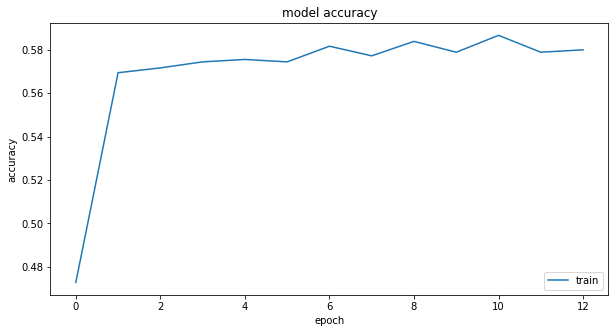

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='lower right')
plt.show()

In [ ]:
loss = model.evaluate(x_test, y_test)

19/19 [==============================] - 1s 31ms/step - loss: 1.2666 - accuracy: 0.5967


In [ ]:
from tensorflow import keras
BATCH_SIZE = 32
EPOCHS = 100
opt=keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS)

Epoch 1/100
57/57 [==============================] - 6s 37ms/step - loss: 1.1579 - accuracy: 0.6038 - val_loss: 1.4486 - val_accuracy: 0.4750
Epoch 2/100
57/57 [==============================] - 1s 20ms/step - loss: 1.1549 - accuracy: 0.5859 - val_loss: 1.1814 - val_accuracy: 0.6067
Epoch 3/100
57/57 [==============================] - 1s 20ms/step - loss: 1.1517 - accuracy: 0.5942 - val_loss: 2.1332 - val_accuracy: 0.3517
Epoch 4/100
57/57 [==============================] - 1s 20ms/step - loss: 1.2029 - accuracy: 0.5597 - val_loss: 2.1750 - val_accuracy: 0.3517


In [ ]:
loss = model.evaluate(x_test, y_test)

19/19 [==============================] - 0s 12ms/step - loss: 1.1644 - accuracy: 0.6033


In [ ]:
model.save_weights('blstm_60_ckpt')

In [ ]:
model.save('model_60.h5')

## Relation between gender and emotion expression

In [ ]:
loaded_model = blstm_model(load_weights=True)

In [ ]:
loss = loaded_model.evaluate(x_test, y_test)

19/19 [==============================] - 0s 13ms/step - loss: 1.1611 - accuracy: 0.5983


In [ ]:
mels = pickle.load(open('melspectrogram_all.pkl', 'rb'))

In [ ]:
for i in range(len(mels)):
    mels[i] = mels[i].reshape(128, 1)

In [ ]:
mels = np.asarray(mels)

In [ ]:
female_mels = mels[:len(female_voice_label)]
male_mels   = mels[len(female_voice_label):]
female_voice_label = voice_label[:len(female_voice_label)]
male_voice_label = voice_label[len(female_voice_label):]

In [ ]:
def split_data(data, label, test_size=0.4, num_classes=6, val=True):
    from sklearn.model_selection import train_test_split
    data = np.asarray(data)
    label = np.asarray(label)
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=test_size ,shuffle=True)
    y_train = np_utils.to_categorical(y_train, num_classes=num_classes)
    y_test  = np_utils.to_categorical(y_test, num_classes=num_classes)
    if val:
        x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)
        return x_train, x_test, x_val, y_train, y_test, y_val
    else:
        return x_train, x_test, y_train, y_test

In [ ]:
female_x_train, female_x_test, female_y_train, female_y_test = split_data(female_mels, female_voice_label, test_size=0.2, val=False)
male_x_train, male_x_test, male_y_train, male_y_test = split_data(male_mels, male_voice_label, test_size=0.2, val=False)

In [ ]:
female_loss = loaded_model.evaluate(female_x_train, female_y_train)
male_loss   = loaded_model.evaluate(male_x_train, male_y_train)

44/44 [==============================] - 0s 9ms/step - loss: 1.0226 - accuracy: 0.6566


In [ ]:
emotion_dict = {0: 'Angry', 1: 'Happy', 2: 'Sadness', 3: 'W...', 4: 'Neutral', 5: 'Fear'}

In [ ]:
gender_dict = {0:'female', 1:'male'}

In [ ]:
for gender in [0,1]:
    print(f'\n\nGender: {gender_dict[gender]}\n\n')
    for i in range(len(emotion_classes)):
        if gender == 0:
            print(f'Emotion: {emotion_dict[i]}')
            indices = [idx for idx, x in enumerate(female_voice_label) if x == i]
            data = [mels[idx] for idx in indices]
            label= [i for idx in range(len(data))]
            x_train, x_test, y_train, y_test = split_data(female_mels, female_voice_label, test_size=0.2, val=False)
            loss, accuracy = loaded_model.evaluate(x_train, y_train, verbose=0)
            print(f'\t loss: {loss:.2f}, accuracy: {accuracy:.2f}')
        else:
            print(f'Emotion: {emotion_dict[i]}')
            indices = [idx+len(female_voice_label) for idx, x in enumerate(male_voice_label) if x == i]
            data = [mels[idx] for idx in indices]
            label= [i for idx in range(len(data))]
            x_train, x_test, y_train, y_test = split_data(male_mels, male_voice_label, test_size=0.2, val=False)
            loss, accuracy = loaded_model.evaluate(x_train, y_train, verbose=0)
            print(f'\t loss: {loss:.2f}, accuracy: {accuracy:.2f}')



Gender: female


Emotion: Angry
	 loss: 1.32, accuracy: 0.53
Emotion: Happy
	 loss: 1.28, accuracy: 0.54
Emotion: Sadness
	 loss: 1.32, accuracy: 0.53
Emotion: W...
	 loss: 1.29, accuracy: 0.54
Emotion: Neutral
	 loss: 1.29, accuracy: 0.54
Emotion: Fear
	 loss: 1.32, accuracy: 0.52


Gender: male


Emotion: Angry
	 loss: 1.01, accuracy: 0.66
Emotion: Happy
	 loss: 1.02, accuracy: 0.65
Emotion: Sadness
	 loss: 1.00, accuracy: 0.67
Emotion: W...
	 loss: 1.01, accuracy: 0.66
Emotion: Neutral
	 loss: 1.03, accuracy: 0.65
Emotion: Fear
	 loss: 1.02, accuracy: 0.65


# Further Experiments

In [ ]:
# generate stft features for all voices
mels2d      = []
for voice in voice_dir:
    y, sr = librosa.load(voice)
    melspec = librosa.feature.melspectrogram(y, sr=sr, fmax=8000)
    mels2d.append(melspec)

In [ ]:
pickle.dump(mels2d, open('mels2d.pkl', 'wb'))

In [ ]:
mels2d = pickle.load(open('mels2d.pkl', 'rb'))

In [ ]:
for i in range(len(mels2d)):
    mels2d[i] = mels2d[i].reshape(mels2d[i].shape[0], mels2d[i].shape[1], 1)

In [ ]:
print(len(mels2d), mels2d[0].shape)

3000 (128, 84)


In [ ]:
mels2d_resized = []
for mel in mels2d:
    temp = tf.constant(mel)
    temp = temp[..., tf.newaxis]
    temp = tf.image.resize(temp, [128,128], method='nearest')
    mels2d_resized.append(temp)

In [ ]:
print(len(mels2d_resized), mels2d_resized[0].shape)

3000 (128, 128, 1)


In [ ]:
# Miscellaneous
# test = tf.constant(mels2d[0])
# test = test[..., tf.newaxis]
# test = tf.image.resize(test, [128,128], method='nearest')
# test.shape

In [ ]:
def crnn_model(load_weights=False, weights_path='blstm_60_ckpt'):
    from tensorflow.keras.layers import (
        Bidirectional, LSTM, Dropout,
        Input, Dense, Conv2D, Conv1D,
        MaxPooling2D, Reshape,
        BatchNormalization)

    model = tf.keras.Sequential([
        Input(shape=(128, 128, 1)),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv1D(8, 3, activation='relu'),
        MaxPooling2D(),
        Conv1D(1, 3, activation='relu'),
        Reshape((40, 1)),
        Bidirectional(LSTM(60, return_sequences=True)),
        Bidirectional(LSTM(60, return_sequences=True)),
        LSTM(60, return_sequences=True),
        LSTM(60),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(8, activation='tanh'),
        Dense(len(emotion_classes), activation='softmax')
    ])
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
    if load_weights:
        model.load_weights(weights_path)
    opt=tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
crnn = crnn_model()

In [ ]:
crnn.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 128, 128, 128)     1280      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 64, 64, 64)        73792     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 16, 14, 8)       

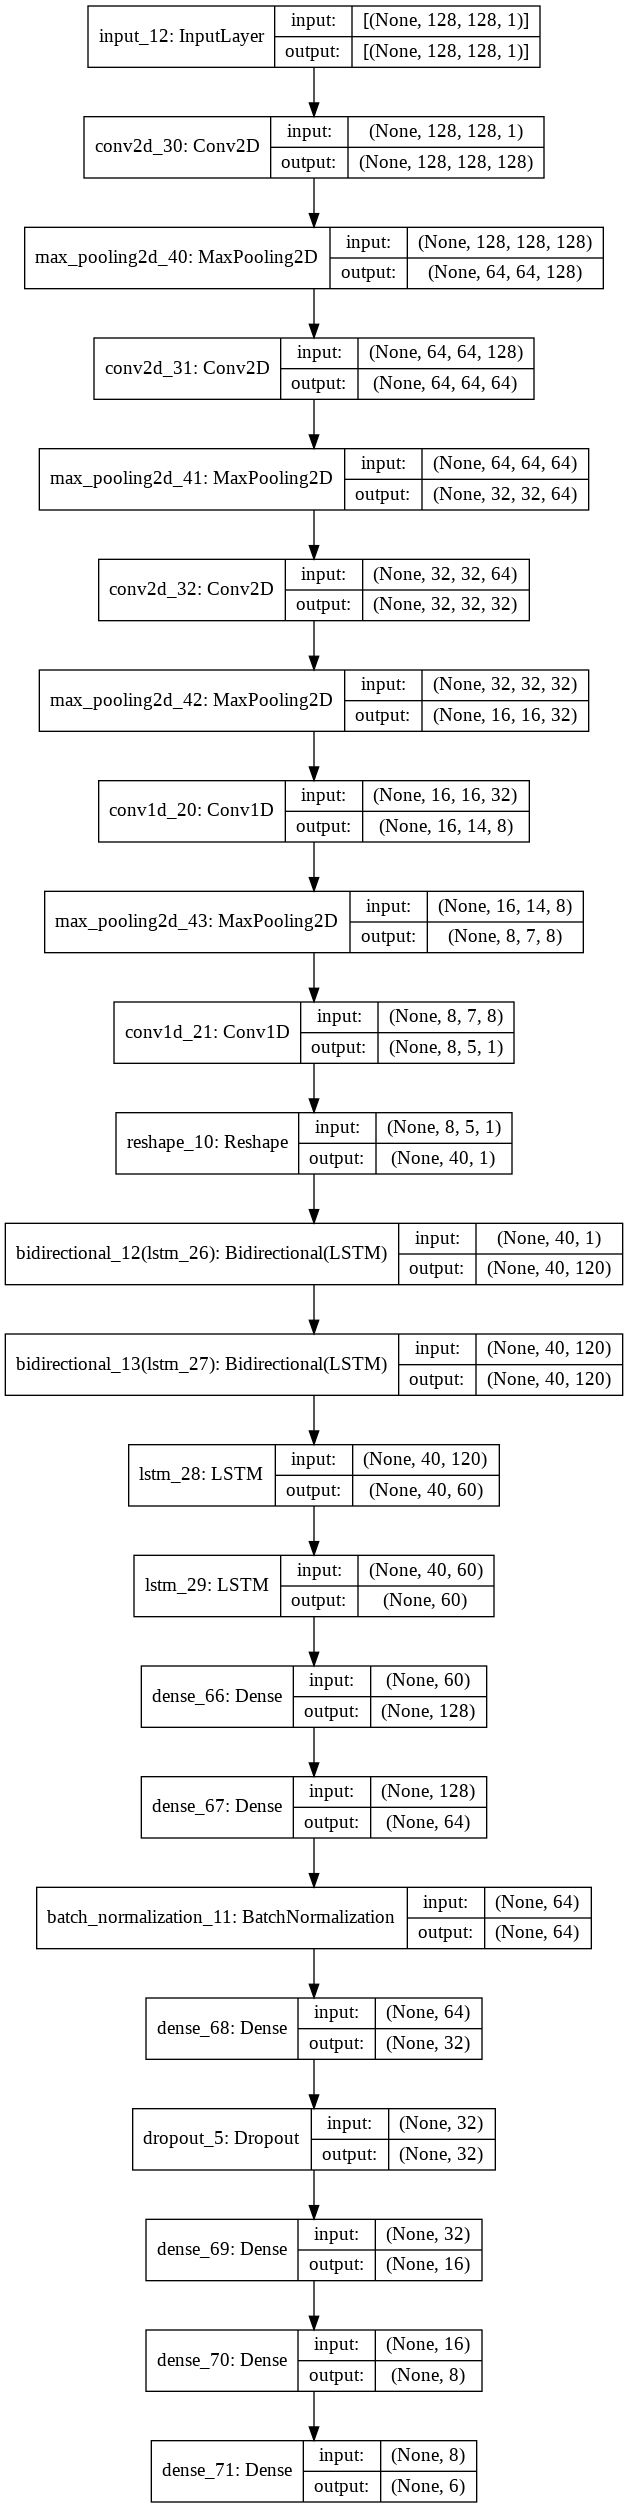

In [ ]:
from keras.utils import plot_model
plot_model(crnn, show_shapes=True)

In [ ]:
x_train, x_test, x_val, y_train, y_test, y_val = split_data(mels2d_resized, voice_label, )

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
BATCH_SIZE = 16
EPOCHS = 100
history = crnn.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS)

Epoch 1/100
113/113 [==============================] - 12s 44ms/step - loss: 1.4937 - accuracy: 0.5152 - val_loss: 1.6659 - val_accuracy: 0.3400
Epoch 2/100
113/113 [==============================] - 3s 30ms/step - loss: 1.1742 - accuracy: 0.6097 - val_loss: 1.4808 - val_accuracy: 0.5867
Epoch 3/100
113/113 [==============================] - 3s 30ms/step - loss: 1.1152 - accuracy: 0.6219 - val_loss: 1.6039 - val_accuracy: 0.4217
Epoch 4/100
113/113 [==============================] - 3s 29ms/step - loss: 1.1262 - accuracy: 0.6094 - val_loss: 1.3791 - val_accuracy: 0.5333
Epoch 5/100
113/113 [==============================] - 3s 29ms/step - loss: 1.0516 - accuracy: 0.6497 - val_loss: 1.7704 - val_accuracy: 0.1433
Epoch 6/100
113/113 [==============================] - 3s 30ms/step - loss: 1.0797 - accuracy: 0.6250 - val_loss: 1.2558 - val_accuracy: 0.5583
Epoch 7/100
113/113 [==============================] - 3s 30ms/step - loss: 1.0505 - accuracy: 0.6425 - val_loss: 1.6369 - val_accuracy

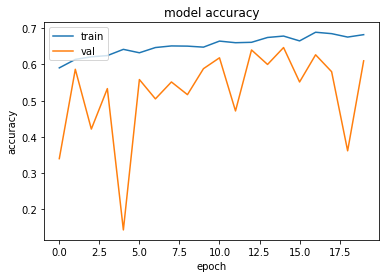

In [ ]:
# plt.figure(figsize = (10,5))
# plt.plot(history.history['accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train'], loc='lower right')
# plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss = crnn.evaluate(x_test, y_test)

19/19 [==============================] - 0s 18ms/step - loss: 1.0279 - accuracy: 0.6617


In [ ]:
crnn.save_weights('crnn_66_cpkt')
crnn.save('crnn_66.h5')

# Further Experiments (balancing the data)

In [ ]:
# generate stft features for all voices
mels2d      = []
for voice in voice_dir:
    y, sr = librosa.load(voice)
    melspec = librosa.feature.melspectrogram(y, sr=sr, fmax=8000)
    mels2d.append(melspec)

In [ ]:
pickle.dump(mels2d, open('mels2d.pkl', 'wb'))

In [ ]:
mels2d = pickle.load(open('processed_data/mels2d.pkl', 'rb'))

In [ ]:
for i in range(len(mels2d)):
    mels2d[i] = mels2d[i].reshape(mels2d[i].shape[0], mels2d[i].shape[1])

In [ ]:
print(len(mels2d), mels2d[0].shape)

3000 (128, 84)


In [ ]:
mels2d_resized = []
for mel in mels2d:
    temp = tf.constant(mel)
    temp = temp[..., tf.newaxis]
    temp = tf.image.resize(temp, [128,128], method='nearest')
    mels2d_resized.append(temp)

In [ ]:
print(len(mels2d_resized), mels2d_resized[0].shape)

3000 (128, 128, 1)


In [ ]:
def crnn_model(load_weights=False, weights_path='blstm_60_ckpt'):
    from tensorflow.keras.layers import (
        Bidirectional, LSTM, Dropout,
        Input, Dense, Conv2D, Conv1D,
        MaxPooling2D, Reshape,
        BatchNormalization)

    model = tf.keras.Sequential([
        Input(shape=(128, 128, 1)),BatchNormalization(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),

        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        BatchNormalization(),
        Conv1D(8, 3, activation='relu'),
        MaxPooling2D(),
        Conv1D(1, 3, activation='relu'),
        Reshape((40, 1)),
        Bidirectional(LSTM(60, return_sequences=True)),
        Bidirectional(LSTM(60, return_sequences=True)),
        LSTM(60, return_sequences=True),
        LSTM(60),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(32, activation='relu'),

        Dropout(0.2),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dense(8, activation='tanh'),
        Dense(len(emotion_classes), activation='softmax')
    ])
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
    if load_weights:
        model.load_weights(weights_path)
    # opt=tf.keras.optimizers.Adam(learning_rate=0.00001)
    opt=tf.keras.optimizers.SGD(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
crnn = crnn_model()

In [ ]:
x_train, x_test, x_val, y_train, y_test, y_val = split_data(mels2d_resized, voice_label, )

In [ ]:
y_train.sum(axis=0)

array([627., 119., 285., 142., 605.,  22.], dtype=float32)

the data are imabalance

In [ ]:
classTotals = y_train.sum(axis=0)
classWeight = classTotals.max() / classTotals
print(classWeight)


[ 1.         5.2689075  2.2        4.415493   1.0363636 28.5      ]


In [ ]:
classWeight={i:classWeight[i] for i in range (classWeight.size)}
print(classWeight)

{0: 1.0, 1: 5.2689075, 2: 2.2, 3: 4.415493, 4: 1.0363636, 5: 28.5}


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
BATCH_SIZE = 16
EPOCHS = 100

history = crnn.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,class_weight=classWeight)

Epoch 1/100
113/113 [==============================] - 4s 34ms/step - loss: 3.2986 - accuracy: 0.4494 - val_loss: 2.4013 - val_accuracy: 0.3583
Epoch 2/100
113/113 [==============================] - 4s 32ms/step - loss: 3.2764 - accuracy: 0.4706 - val_loss: 2.4253 - val_accuracy: 0.3583
Epoch 3/100
113/113 [==============================] - 4s 33ms/step - loss: 3.2935 - accuracy: 0.4250 - val_loss: 2.4211 - val_accuracy: 0.3583
Epoch 4/100
113/113 [==============================] - 4s 32ms/step - loss: 3.3074 - accuracy: 0.4144 - val_loss: 2.4335 - val_accuracy: 0.3583
Epoch 5/100
113/113 [==============================] - 4s 33ms/step - loss: 3.2374 - accuracy: 0.4367 - val_loss: 2.1720 - val_accuracy: 0.3600
Epoch 6/100
113/113 [==============================] - 4s 33ms/step - loss: 3.2395 - accuracy: 0.4289 - val_loss: 2.1580 - val_accuracy: 0.3583
Epoch 7/100
113/113 [==============================] - 4s 33ms/step - loss: 3.2772 - accuracy: 0.4078 - val_loss: 1.8552 - val_accuracy:

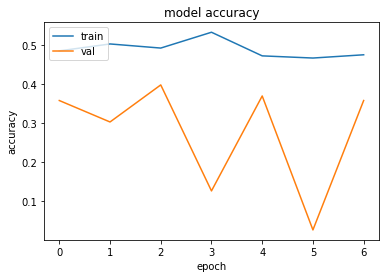

In [ ]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss = crnn.evaluate(x_test, y_test)

19/19 [==============================] - 0s 18ms/step - loss: 1.0279 - accuracy: 0.6617


In [ ]:
crnn.save_weights('crnn_66_cpkt')
crnn.save('crnn_66.h5')